# Long Short-Term Memory (LSTM)

Algoritma Long Short Term Memory (LSTM) adalah turunan istimewa dari Recurrent Neural Network (RNN) yang dirancang untuk mengatasi kelemahan RNN dalam menangani urutan data yang panjang. LSTM memiliki kemampuan untuk menyimpan informasi penting dalam jangka waktu yang lama, membuatnya ideal untuk berbagai aplikasi yang melibatkan data sekuensial.  
![image.png](lstm-flow.png)

# A. Menyiapkan Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# B. Memuat Data

In [2]:
data = pd.read_csv('final.csv')
data['datetime'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %H:%M:%S')
# sort data by datetime
# change datetime that has d/m/y 00:00:00, change to d+1/m/y 00:00:00
data['datetime'] = data['datetime'].apply(lambda x: x + pd.DateOffset(days=1) if x.strftime('%H:%M:%S') == '00:00:00' else x)
data = data.sort_values('datetime')

data

,datetime,choke,psig,apsig,oil,gas,water,liquid
0,2021-05-15 21:00:00,38,935,320,698.880,4.980,23.616,722.5
1,2021-05-15 21:15:00,38,935,321,822.456,4.988,32.592,855.0
2,2021-05-15 21:30:00,38,940,318,661.368,5.070,26.208,687.6
3,2021-05-15 21:45:00,38,938,317,737.664,5.061,29.232,766.9
4,2021-05-15 22:00:00,38,940,319,661.368,5.078,26.208,687.6
...,...,...,...,...,...,...,...,...
1873,2021-06-04 08:00:00,42,986,328,771.720,7.638,16.896,788.6
1874,2021-06-04 08:15:00,42,984,325,766.032,7.602,16.704,782.7
1875,2021-06-04 08:30:00,42,986,328,765.216,7.638,16.704,781.9
1876,2021-06-04 08:45:00,42,988,326,757.224,7.614,16.512,773.7


# C. Pemisahan Data Berdasarkan Nilai Choke
Termasuk menghapus kolom choke karena tidak diperlukan dalam pemodelan

## 1. Berapa choke yang ada dalam data?

In [3]:
data['choke'].value_counts()

choke
38    854
40    645
42    379
Name: count, dtype: int64

## 2. Memisahkan data berdasarkan nilai choke yang ada

In [4]:
data_38 = data[data['choke'] == 38].drop(['datetime', 'choke'], axis=1)
data_40 = data[data['choke'] == 40].drop(['datetime', 'choke'], axis=1)
data_42 = data[data['choke'] == 42].drop(['datetime', 'choke'], axis=1)

# Menampilkan Data
display('Data Choke 38', data_38.describe())
display('Data Choke 40', data_40.describe())
display('Data Choke 42', data_42.describe())

'Data Choke 38'

,psig,apsig,oil,gas,water,liquid
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,1007.033958,325.594848,761.594501,5.987358,17.394857,778.921077
std,73.533621,7.364072,45.464697,0.562406,7.202383,49.189237
min,835.000000,304.000000,610.704000,4.745000,6.144000,627.800000
25%,934.250000,320.000000,733.080000,5.279250,14.976000,747.400000
50%,1050.000000,328.000000,757.560000,6.267000,16.512000,775.100000
75%,1054.000000,331.000000,788.448000,6.384000,22.704000,812.225000
max,1067.000000,340.000000,893.448000,6.579000,48.000000,923.500000


'Data Choke 40'

,psig,apsig,oil,gas,water,liquid
count,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
mean,1021.804651,331.893023,767.669991,7.038047,15.788130,783.326512
std,5.367747,5.293207,27.692167,0.059675,3.047829,27.905772
min,1004.000000,318.000000,712.440000,6.888000,7.872000,728.000000
25%,1018.000000,327.000000,747.168000,7.000000,15.936000,763.200000
50%,1022.000000,334.000000,765.216000,7.038000,16.512000,781.100000
75%,1026.000000,336.000000,786.792000,7.077000,16.896000,803.900000
max,1039.000000,340.000000,839.832000,7.230000,31.920000,858.900000


'Data Choke 42'

,psig,apsig,oil,gas,water,liquid
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,988.068602,326.704485,800.717636,7.557427,17.555208,818.266755
std,4.861635,2.377642,16.509230,0.066787,1.365055,16.803696
min,982.000000,320.000000,757.224000,7.292000,9.024000,773.700000
25%,985.000000,325.000000,790.080000,7.544500,17.280000,807.400000
50%,986.000000,327.000000,800.400000,7.575000,17.472000,817.900000
75%,990.000000,328.000000,815.568000,7.599000,17.856000,833.400000
max,1018.000000,333.000000,845.280000,7.673000,27.072000,863.700000


# D. Normalisasi Data

## 1. Membuat fungsi untuk normalisasi data

In [5]:
def normalize_dataframe(df, method='min-max', range_min=0.0, range_max=1.0):
    # Normalisasi Data metode Min-Max
    # df: DataFrame
    # method: metode normalisasi, standard atau min-max
    # range_min: nilai minimum setelah normalisasi, only for min-max method
    # range_max: nilai maksimum setelah normalisasi, only for min-max method
    # return: DataFrame yang sudah dinormalisasi

    assert isinstance(df, pd.DataFrame), 'df harus bertipe DataFrame'

    # Membuat salinan DataFrame
    df_normalized = df.copy()

    if method == 'standard':
        # Normalisasi menggunakan metode standard
        df_normalized = (df - df.mean()) / df.std()
        
        return df_normalized
    
    #  Iterasi setiap kolom dalam DataFrame
    for column in df.columns:
        # Ambil nilai minimum dan maksimum dari kolom
        min_value = df[column].min()
        max_value = df[column].max()
        
        # Normalisasi setiap nilai dalam kolom
        df_normalized[column] = (df[column] - min_value) / (max_value - min_value) * (range_max - range_min) + range_min
    return df_normalized

## 2. Menormalisasi Data

In [6]:
data_38_normalized = normalize_dataframe(data_38, range_min=0.001)
data_40_normalized = normalize_dataframe(data_40, range_min=0.001)
data_42_normalized = normalize_dataframe(data_42, range_min=0.001)

# Menampilkan Data
display('Data Choke 38', data_38_normalized.describe())
display('Data Choke 40', data_40_normalized.describe())
display('Data Choke 42', data_42_normalized.describe())

'Data Choke 38'

,psig,apsig,oil,gas,water,liquid
count,854.000000,854.000000,854.000000,854.000000,854.000000,854.000000
mean,0.741784,0.600257,0.534131,0.677726,0.269530,0.511551
std,0.316638,0.204353,0.160637,0.306349,0.171903,0.166182
min,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
25%,0.428374,0.445000,0.433383,0.292012,0.211798,0.405060
50%,0.926797,0.667000,0.519876,0.830050,0.248459,0.498642
75%,0.944022,0.750250,0.629011,0.893781,0.396247,0.624066
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


'Data Choke 40'

,psig,apsig,oil,gas,water,liquid
count,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
mean,0.509196,0.631870,0.434110,0.439294,0.329851,0.423240
std,0.153211,0.240360,0.217160,0.174313,0.126613,0.212971
min,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
25%,0.400600,0.409682,0.273335,0.328158,0.335994,0.269639
50%,0.514771,0.727545,0.414866,0.439158,0.359922,0.406248
75%,0.628943,0.818364,0.584064,0.553079,0.375874,0.580252
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


'Data Choke 42'

,psig,apsig,oil,gas,water,liquid
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,0.169404,0.516214,0.494438,0.696963,0.473223,0.495691
std,0.134910,0.182713,0.187298,0.175119,0.075559,0.186521
min,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000
25%,0.084250,0.385231,0.373753,0.663067,0.457989,0.375070
50%,0.112000,0.538923,0.490834,0.743039,0.468617,0.491620
75%,0.223000,0.615769,0.662916,0.805969,0.489872,0.663670
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# E. Mengubah Data Series Menjadi Data Supervised

## 1. Membuat Fungsi untuk Membuat Data Supervised

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()

	columns = dff.columns

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		# names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		names += [(columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			# names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
			names += [(columns[j]+'(t)') for j in range(n_vars)]
		else:
			# names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
			names += [(columns[j]+'(t+%d)' % (i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## 2. Menggunakan Fungsi untuk Membuat Data Supervised

In [8]:
supervised_38 = series_to_supervised(data_38_normalized, 1, 1)
supervised_40 = series_to_supervised(data_40_normalized, 1, 1)
supervised_42 = series_to_supervised(data_42_normalized, 1, 1)

# Menampilkan Data
display('Data Choke 38', supervised_38.head())
display('Data Choke 40', supervised_40.head())
display('Data Choke 42', supervised_42.head())

'Data Choke 38'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1),psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
1,0.431603,0.44500,0.312546,0.129007,0.418014,0.320937,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578
2,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030
3,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939
4,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030
5,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030,0.461746,0.41725,0.359778,0.182389,0.527995,0.381748


'Data Choke 40'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1),psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
855,0.001000,0.772955,0.653324,0.450842,0.391826,0.648938,0.200800,0.909182,0.653324,0.544316,0.391826,0.648938
856,0.200800,0.909182,0.653324,0.544316,0.391826,0.648938,0.257886,0.818364,0.557903,0.480053,0.930210,0.655044
857,0.257886,0.818364,0.557903,0.480053,0.930210,0.655044,0.400600,0.727545,0.899121,0.652395,1.000000,1.000000
858,0.400600,0.727545,0.899121,0.652395,1.000000,1.000000,0.457686,1.000000,0.759472,1.000000,0.591228,0.788600
859,0.457686,1.000000,0.759472,1.000000,0.591228,0.788600,0.400600,1.000000,0.899121,0.921132,1.000000,1.000000


'Data Choke 42'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1),psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
1500,1.00000,0.615769,0.496824,0.184543,0.968117,0.59707,0.91675,0.462077,0.895989,0.124236,0.001000,0.79354
1501,0.91675,0.462077,0.895989,0.124236,0.001000,0.79354,0.83350,0.385231,0.996733,0.092772,0.006314,0.89344
1502,0.83350,0.385231,0.996733,0.092772,0.006314,0.89344,0.72250,0.154692,0.948539,0.001000,0.258721,0.89677
1503,0.72250,0.154692,0.948539,0.001000,0.258721,0.89677,0.77800,0.385231,1.000000,0.092772,0.521755,1.00000
1504,0.77800,0.385231,1.000000,0.092772,0.521755,1.00000,0.66700,0.154692,0.900073,0.105882,0.511128,0.90010


# F. Membagi Data Menjadi Data Training dan Data Testing

In [9]:
train_ratio = 0.8

train_length_38 = int(len(supervised_38) * train_ratio)
train_length_40 = int(len(supervised_40) * train_ratio)
train_length_42 = int(len(supervised_42) * train_ratio)

train_38_X = supervised_38.iloc[:train_length_38, :6]
train_38_y = supervised_38.iloc[:train_length_38, 6:]
test_38_X = supervised_38.iloc[train_length_38:, :6]
test_38_y = supervised_38.iloc[train_length_38:, 6:]

train_40_X = supervised_40.iloc[:train_length_40, :6]
train_40_y = supervised_40.iloc[:train_length_40, 6:]
test_40_X = supervised_40.iloc[train_length_40:, :6]
test_40_y = supervised_40.iloc[train_length_40:, 6:]

train_42_X = supervised_42.iloc[:train_length_42, :6]
train_42_y = supervised_42.iloc[:train_length_42, 6:]
test_42_X = supervised_42.iloc[train_length_42:, :6]
test_42_y = supervised_42.iloc[train_length_42:, 6:]

# Menampilkan Data
display('Data Choke 38', train_38_X.head(), train_38_y.head(), test_38_X.head(), test_38_y.head())

'Data Choke 38'

,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1)
1,0.431603,0.44500,0.312546,0.129007,0.418014,0.320937
2,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578
3,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030
4,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939
5,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030


,psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
1,0.431603,0.47275,0.749169,0.133365,0.632249,0.768578
2,0.453134,0.38950,0.180008,0.178031,0.479878,0.203030
3,0.444522,0.36175,0.449579,0.173129,0.552054,0.470939
4,0.453134,0.41725,0.180008,0.182389,0.479878,0.203030
5,0.461746,0.41725,0.359778,0.182389,0.527995,0.381748


,psig(t-1),apsig(t-1),oil(t-1),gas(t-1),water(t-1),liquid(t-1)
683,0.939716,0.63925,0.394037,0.903586,0.095515,0.353032
684,0.944022,0.69475,0.451699,0.914480,0.139623,0.414519
685,0.944022,0.69475,0.428125,0.914480,0.080049,0.383438
686,0.939716,0.69475,0.433383,0.914480,0.042243,0.383438
687,0.939716,0.66700,0.499186,0.909033,0.027350,0.444249


,psig(t),apsig(t),oil(t),gas(t),water(t),liquid(t)
683,0.944022,0.69475,0.451699,0.914480,0.139623,0.414519
684,0.944022,0.69475,0.428125,0.914480,0.080049,0.383438
685,0.939716,0.69475,0.433383,0.914480,0.042243,0.383438
686,0.939716,0.66700,0.499186,0.909033,0.027350,0.444249
687,0.948328,0.66700,0.533529,0.909033,0.010165,0.474655


In [10]:
print("train_38_X shape: ", train_38_X.shape)
print("train_38_y shape: ", train_38_y.shape)
print("test_38_X shape: ", test_38_X.shape)
print("test_38_y shape: ", test_38_y.shape)

print("train_40_X shape: ", train_40_X.shape)
print("train_40_y shape: ", train_40_y.shape)
print("test_40_X shape: ", test_40_X.shape)
print("test_40_y shape: ", test_40_y.shape)

print("train_42_X shape: ", train_42_X.shape)
print("train_42_y shape: ", train_42_y.shape)
print("test_42_X shape: ", test_42_X.shape)
print("test_42_y shape: ", test_42_y.shape)

train_38_X shape:  (682, 6)
train_38_y shape:  (682, 6)
test_38_X shape:  (171, 6)
test_38_y shape:  (171, 6)
train_40_X shape:  (515, 6)
train_40_y shape:  (515, 6)
test_40_X shape:  (129, 6)
test_40_y shape:  (129, 6)
train_42_X shape:  (302, 6)
train_42_y shape:  (302, 6)
test_42_X shape:  (76, 6)
test_42_y shape:  (76, 6)


# G. Membangun Model LSTM

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Conv1D
tf.random.set_seed(0)

# Check if TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow version: ", tf.__version__)

def get_model_cnn_lstm(future=6, shape=(6, 1), hidden_size=400, learning_rate=0.00001):
    model = Sequential()
    model.add(tf.keras.Input(shape=shape))
    model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=5, activation='relu'))
    model.add(LSTM(hidden_size, return_sequences=True, activation='relu'))
    model.add(LSTM(hidden_size, return_sequences=False, activation='relu'))
    model.add(Dense(future))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

2024-12-08 20:17:14.229818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 20:17:14.240538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 20:17:14.243971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 20:17:14.252291: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1
TensorFlow version:  2.17.0


I0000 00:00:1733663835.577654 1555094 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733663835.614818 1555094 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733663835.616347 1555094 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# H. Melatih Model

## 1. Menentukan Hyperparameter

In [12]:
model_38 = get_model_cnn_lstm()
model_40 = get_model_cnn_lstm()
model_42 = get_model_cnn_lstm()

# display(model_38.summary())
# display(model_40.summary())
# display(model_42.summary())

I0000 00:00:1733663835.627812 1555094 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733663835.629255 1555094 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733663835.630474 1555094 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733663835.730925 1555094 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## 2. Melatih Model

I0000 00:00:1733663838.091477 1555152 service.cc:146] XLA service 0x7f97d000d100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733663838.091495 1555152 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-08 20:17:18.126199: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-08 20:17:18.346420: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
I0000 00:00:1733663839.757940 1555152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-12-08 20:17:20.372916: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1612', 4 bytes spill stores, 4 bytes spill loads



Duration for fitting model_38: 0 hours, 6 minutes, 58.15 seconds


2024-12-08 20:24:17.673599: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1651', 4 bytes spill stores, 4 bytes spill loads



Duration for fitting model_40: 0 hours, 5 minutes, 57.96 seconds


2024-12-08 20:30:15.440896: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1651', 4 bytes spill stores, 4 bytes spill loads



Duration for fitting model_42: 0 hours, 4 minutes, 37.05 seconds


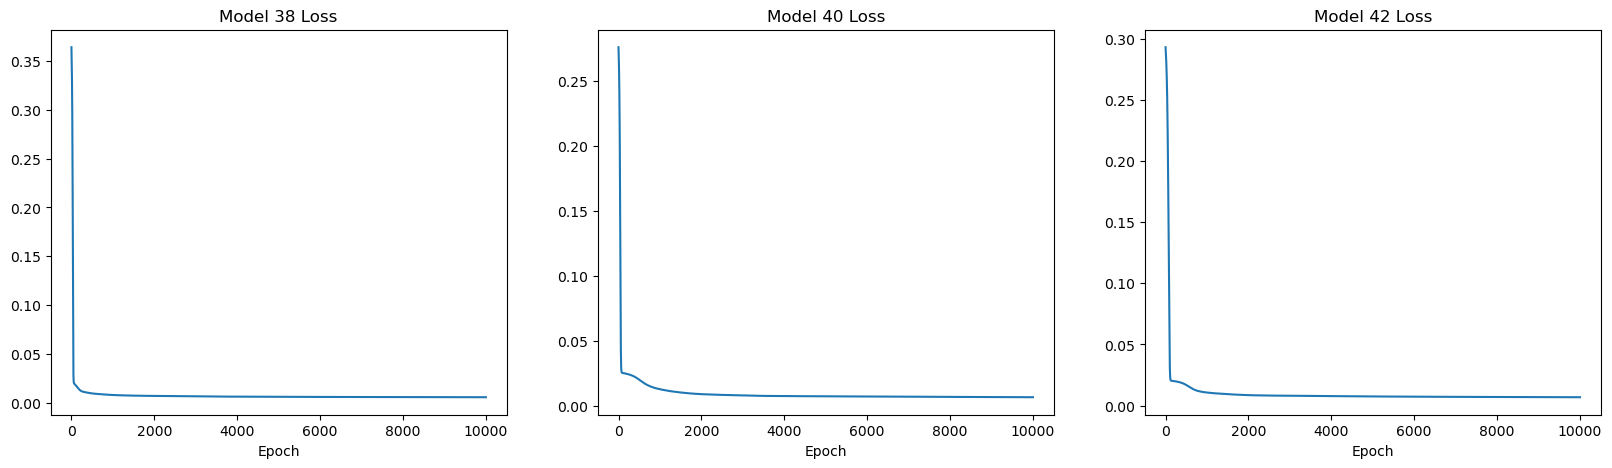

In [13]:
import time

def format_duration(duration):
    hours = duration // 3600
    minutes = (duration % 3600) // 60
    seconds = duration % 60
    return f"{int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds"

start_time_38 = time.time()
history_38 = model_38.fit(train_38_X.values.reshape((train_38_X.shape[0], train_38_X.shape[1], 1)), train_38_y, epochs=10000, batch_size=32, verbose=0)
end_time_38 = time.time()
duration_38 = end_time_38 - start_time_38
print(f"Duration for fitting model_38: {format_duration(duration_38)}")

start_time_40 = time.time()
history_40 = model_40.fit(train_40_X.values.reshape((train_40_X.shape[0], train_40_X.shape[1], 1)), train_40_y, epochs=10000, batch_size=32, verbose=0)
end_time_40 = time.time()
duration_40 = end_time_40 - start_time_40
print(f"Duration for fitting model_40: {format_duration(duration_40)}")

start_time_42 = time.time()
history_42 = model_42.fit(train_42_X.values.reshape((train_42_X.shape[0], train_42_X.shape[1], 1)), train_42_y, epochs=10000, batch_size=32, verbose=0)
end_time_42 = time.time()
duration_42 = end_time_42 - start_time_42
print(f"Duration for fitting model_42: {format_duration(duration_42)}")

model_38.save('cnn-lstm/model_38.h5')
model_40.save('cnn-lstm/model_40.h5')
model_42.save('cnn-lstm/model_42.h5')

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(history_38.history['loss'], label='train')
ax[0].set_title('Model 38 Loss')
ax[0].set_xlabel('Epoch')

ax[1].plot(history_40.history['loss'], label='train')
ax[1].set_title('Model 40 Loss')
ax[1].set_xlabel('Epoch')

ax[2].plot(history_42.history['loss'], label='train')
ax[2].set_title('Model 42 Loss')
ax[2].set_xlabel('Epoch')

plt.show()

In [14]:
model_38 = tf.keras.models.load_model('cnn-lstm/model_38.h5')
model_40 = tf.keras.models.load_model('cnn-lstm/model_40.h5')
model_42 = tf.keras.models.load_model('cnn-lstm/model_42.h5')

# I. Evaluasi Model

In [15]:
# mse and rmse
from sklearn.metrics import mean_squared_error
from math import sqrt

def evaluate_model(model, test_X, test_y):
    yhat = model.predict(test_X.values)
    mse = mean_squared_error(test_y, yhat)
    rmse = sqrt(mse)
    return mse, rmse

mse_38, rmse_38 = evaluate_model(model_38, test_38_X, test_38_y)
mse_40, rmse_40 = evaluate_model(model_40, test_40_X, test_40_y)
mse_42, rmse_42 = evaluate_model(model_42, test_42_X, test_42_y)

print('MSE 38: %.3f, RMSE 38: %.3f' % (mse_38, rmse_38))
print('MSE 40: %.3f, RMSE 40: %.3f' % (mse_40, rmse_40))
print('MSE 42: %.3f, RMSE 42: %.3f' % (mse_42, rmse_42))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/stepWARNING:tensorflow:6 out of the last 14 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f9870391300> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
MSE 38: 0.003, RMSE 38: 0.056
MSE 40: 0.007, RMSE 40: 0.083
MSE 42: 0.013, RMSE 42: 0.113


# J. Prediksi Data

### 1. Data Uji

In [16]:
predictions_38 = model_38.predict(test_38_X.values)
predictions_40 = model_40.predict(test_40_X.values)
predictions_42 = model_42.predict(test_42_X.values)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


### 2. Data Latih

In [17]:
predictions_train_38 = model_38.predict(train_38_X.values)
predictions_train_40 = model_40.predict(train_40_X.values)
predictions_train_42 = model_42.predict(train_42_X.values)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


# K. Denormalisasi Data

## 1. Membuat Fungsi untuk Denormalisasi Data

In [18]:
def denormalize_dataframe(np_normalized, df_original):
    # Denormalisasi DataFrame menggunakan metode Min-Max
    # np_normalized: numpy array yang sudah dinormalisasi
    # df_original: DataFrame asli sebelum dinormalisasi
    # return: DataFrame yang sudah denormalisasi

    assert isinstance(df_original, pd.DataFrame), 'df_original harus bertipe DataFrame'
    assert isinstance(np_normalized, np.ndarray), 'np_normalized harus bertipe numpy array'

    # Membuat salinan DataFrame yang sudah dinormalisasi
    df_normalized = pd.DataFrame(np_normalized, columns=df_original.columns)
    
    # Iterasi setiap kolom dalam DataFrame
    for column in df_normalized.columns:
        # Ambil nilai minimum dan maksimum dari kolom
        min_value = df_original[column].min()
        max_value = df_original[column].max()
        
        # Denormalisasi setiap nilai dalam kolom
        df_normalized[column] = df_normalized[column] * (max_value - min_value) + min_value
        
    return df_normalized

## 2. Denormalisasi Data

In [19]:
denormalized_predictions_38 = denormalize_dataframe(predictions_38, data_38)
denormalized_predictions_40 = denormalize_dataframe(predictions_40, data_40)
denormalized_predictions_42 = denormalize_dataframe(predictions_42, data_42)

denormalized_predictions_train_38 = denormalize_dataframe(predictions_train_38, data_38)
denormalized_predictions_train_40 = denormalize_dataframe(predictions_train_40, data_40)
denormalized_predictions_train_42 = denormalize_dataframe(predictions_train_42, data_42)

denormalized_test_38_y = denormalize_dataframe(test_38_y.values, data_38)
denormalized_test_40_y = denormalize_dataframe(test_40_y.values, data_40)
denormalized_test_42_y = denormalize_dataframe(test_42_y.values, data_42)

denormalized_train_38_y = denormalize_dataframe(train_38_y.values, data_38)
denormalized_train_40_y = denormalize_dataframe(train_40_y.values, data_40)
denormalized_train_42_y = denormalize_dataframe(train_42_y.values, data_42)

# L. Visualisasi Data

## 1. Data Choke 38

In [20]:
import matplotlib.dates as mdates
# Define a function to format x-ticks for datetime
def format_date_ticks(ax, date_format='%Y/%m/%d %H:%M:%S'):
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))


/tmp/ipykernel_1555094/835354804.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


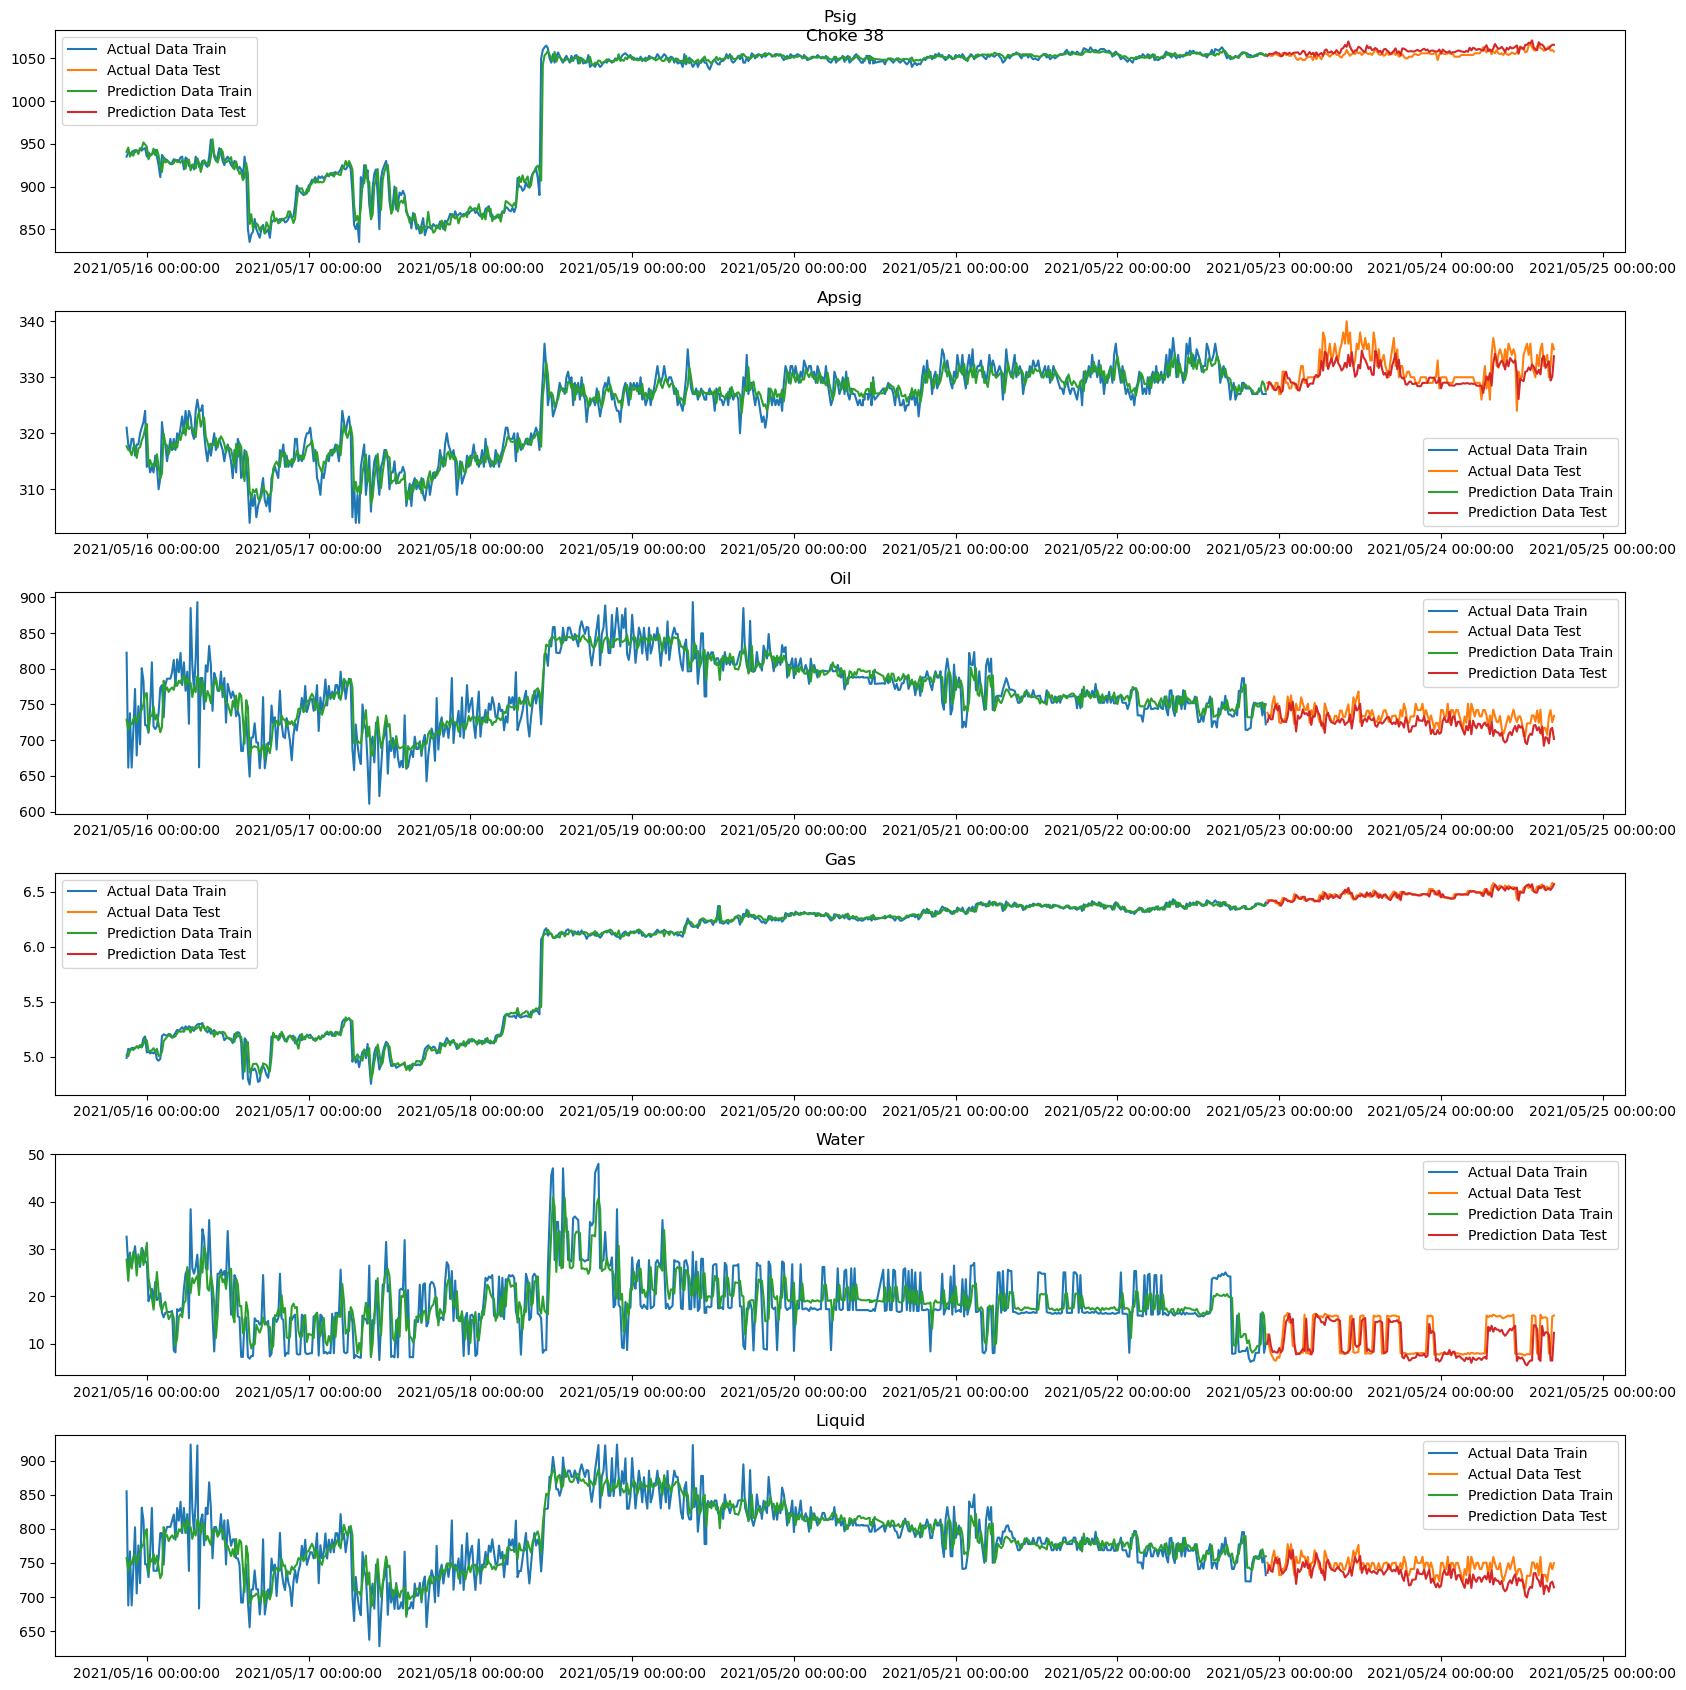

In [21]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_38_y.shape[1])

for i, ax in enumerate(axes):
    # Plot training data
    ax.plot(data['datetime'].iloc[:denormalized_train_38_y.shape[0]],
            denormalized_train_38_y.iloc[:, i], label='Actual Data Train')
    
    # Plot testing data
    ax.plot(data['datetime'].iloc[denormalized_train_38_y.shape[0]:denormalized_train_38_y.shape[0]+denormalized_test_38_y.shape[0]],
        denormalized_test_38_y.iloc[:, i], label='Actual Data Test')
    
    # Plot Prediction Training
    ax.plot(data['datetime'].iloc[:denormalized_train_38_y.shape[0]],
            denormalized_predictions_train_38.iloc[:, i], label='Prediction Data Train')
            
    # Plot predictions
    ax.plot(data['datetime'].iloc[denormalized_train_38_y.shape[0]:denormalized_train_38_y.shape[0]+denormalized_test_38_y.shape[0]],
            denormalized_predictions_38.iloc[:, i], label='Prediction Data Test')
    

    ax.set_title(denormalized_train_38_y.columns[i].capitalize())
    format_date_ticks(ax)
    ax.legend()

    # reset ticks every week data['datetime'] as xticks
    # ax.set_xticks(data.index)
    

plt.tight_layout()
fig.suptitle('Choke 38')
fig.savefig('cnn-lstm/choke_38.png')
fig.show()

## 2. Data Choke 40

/tmp/ipykernel_1555094/2453608780.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


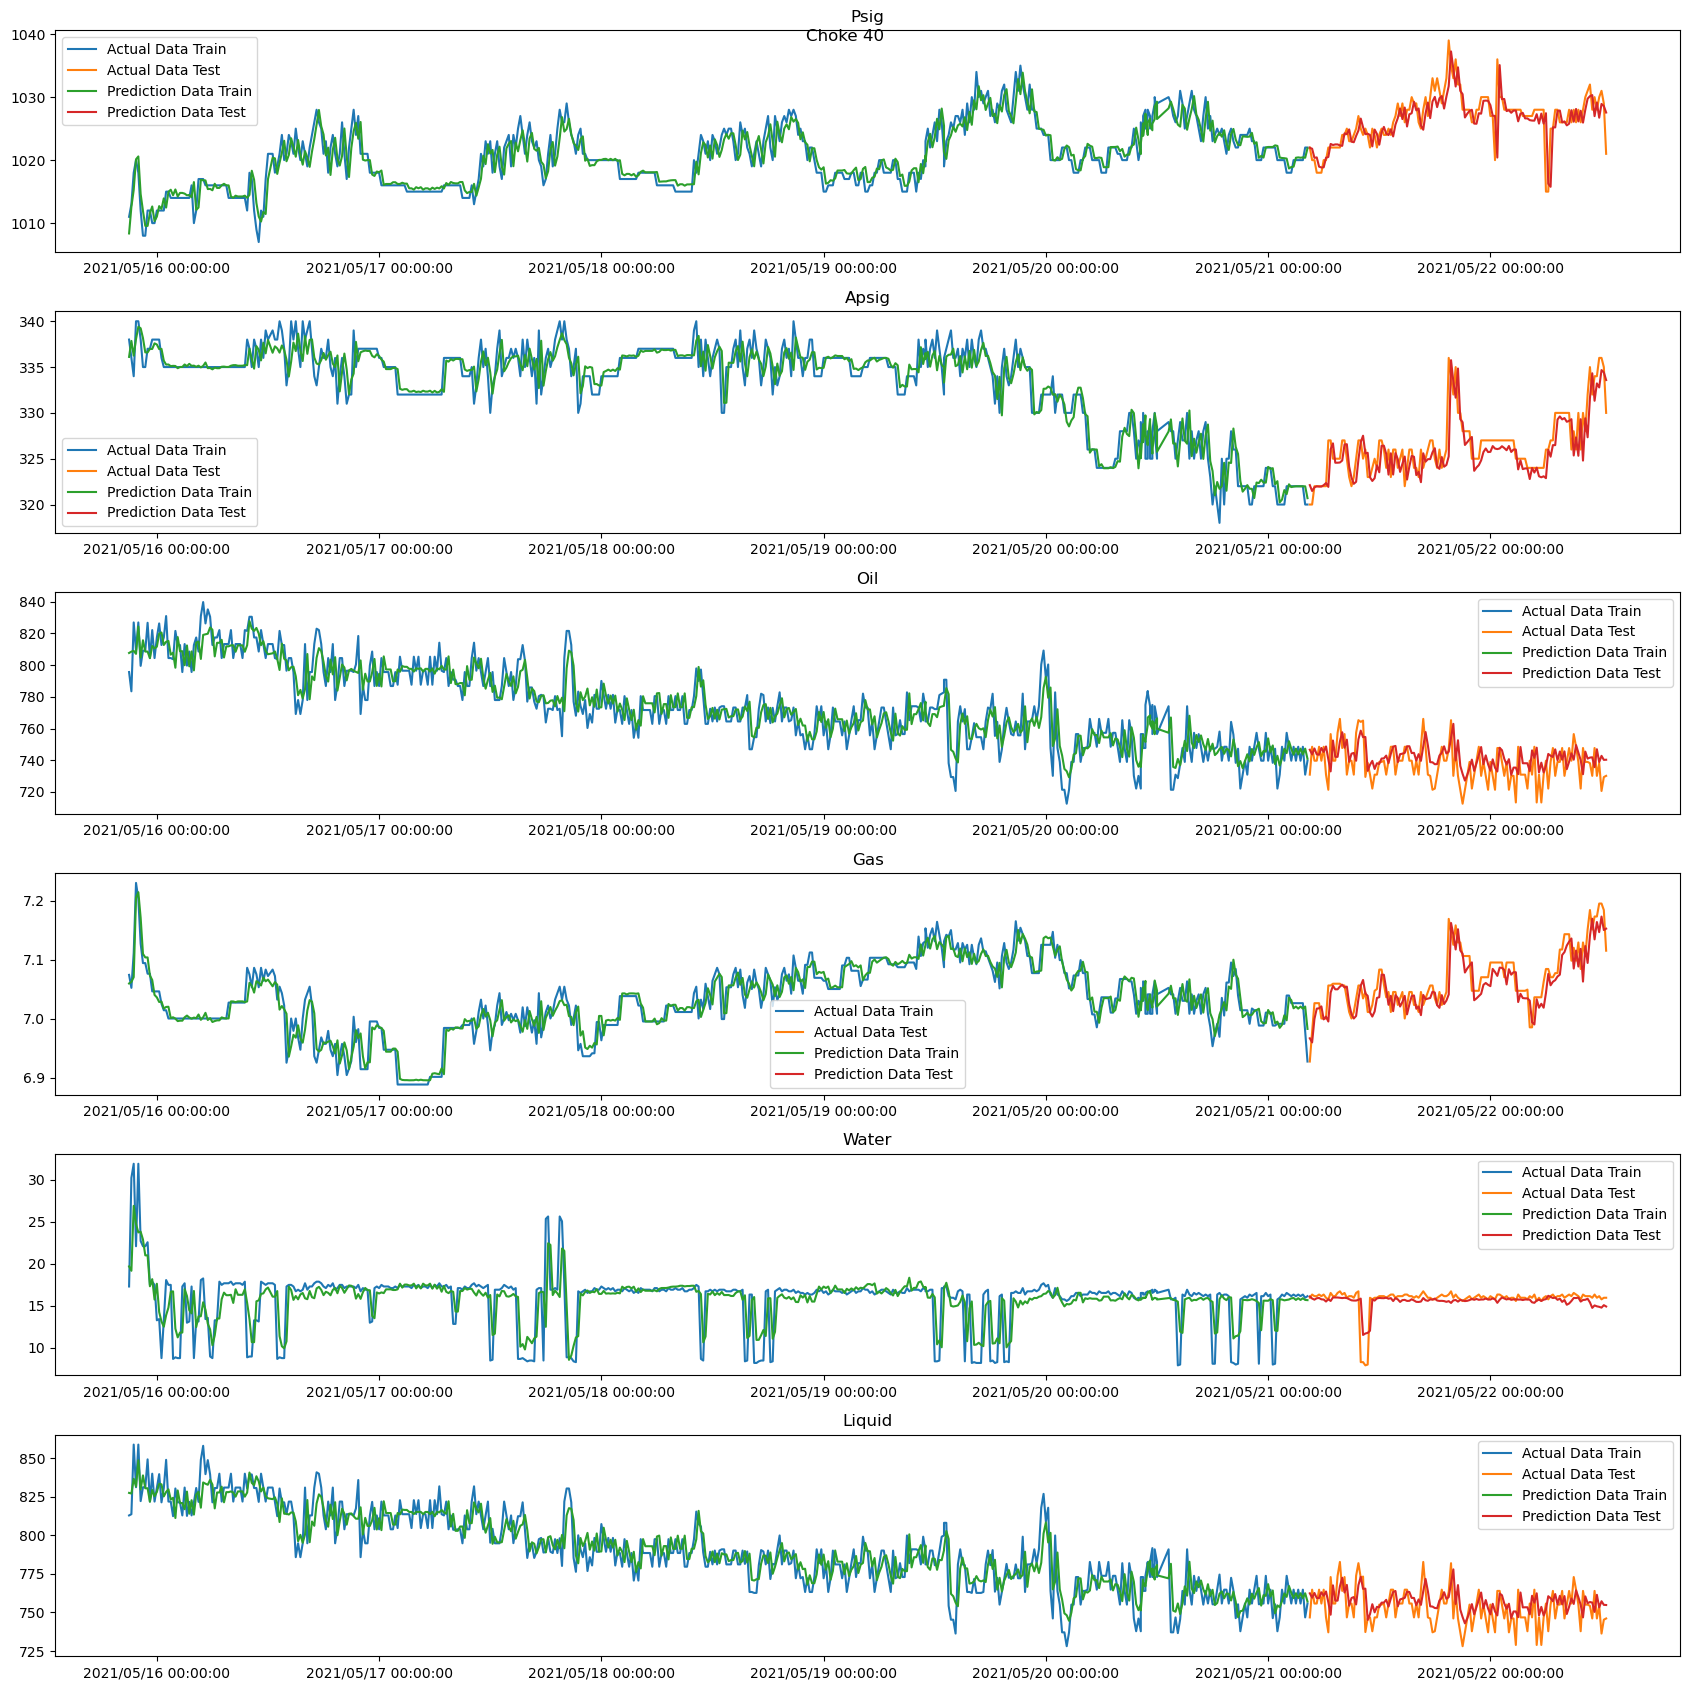

In [22]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_40_y.shape[1])

for i, ax in enumerate(axes):
    # Plot training data
    ax.plot(data['datetime'].iloc[:denormalized_train_40_y.shape[0]],
            denormalized_train_40_y.iloc[:, i], label='Actual Data Train')
    
    # Plot testing data
    ax.plot(data['datetime'].iloc[denormalized_train_40_y.shape[0]:denormalized_train_40_y.shape[0]+denormalized_test_40_y.shape[0]],
        denormalized_test_40_y.iloc[:, i], label='Actual Data Test')
    
    # Plot Prediction Training
    ax.plot(data['datetime'].iloc[:denormalized_train_40_y.shape[0]],
            denormalized_predictions_train_40.iloc[:, i], label='Prediction Data Train')
    
    # Plot predictions
    ax.plot(data['datetime'].iloc[denormalized_train_40_y.shape[0]:denormalized_train_40_y.shape[0]+denormalized_test_40_y.shape[0]],
            denormalized_predictions_40.iloc[:, i], label='Prediction Data Test')
    
    ax.set_title(denormalized_train_40_y.columns[i].capitalize())
    ax.legend()
    format_date_ticks(ax)

fig.tight_layout()
fig.suptitle('Choke 40')
fig.savefig('cnn-lstm/choke_40.png')
fig.show()

## 3. Data Choke 42

/tmp/ipykernel_1555094/2797422158.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


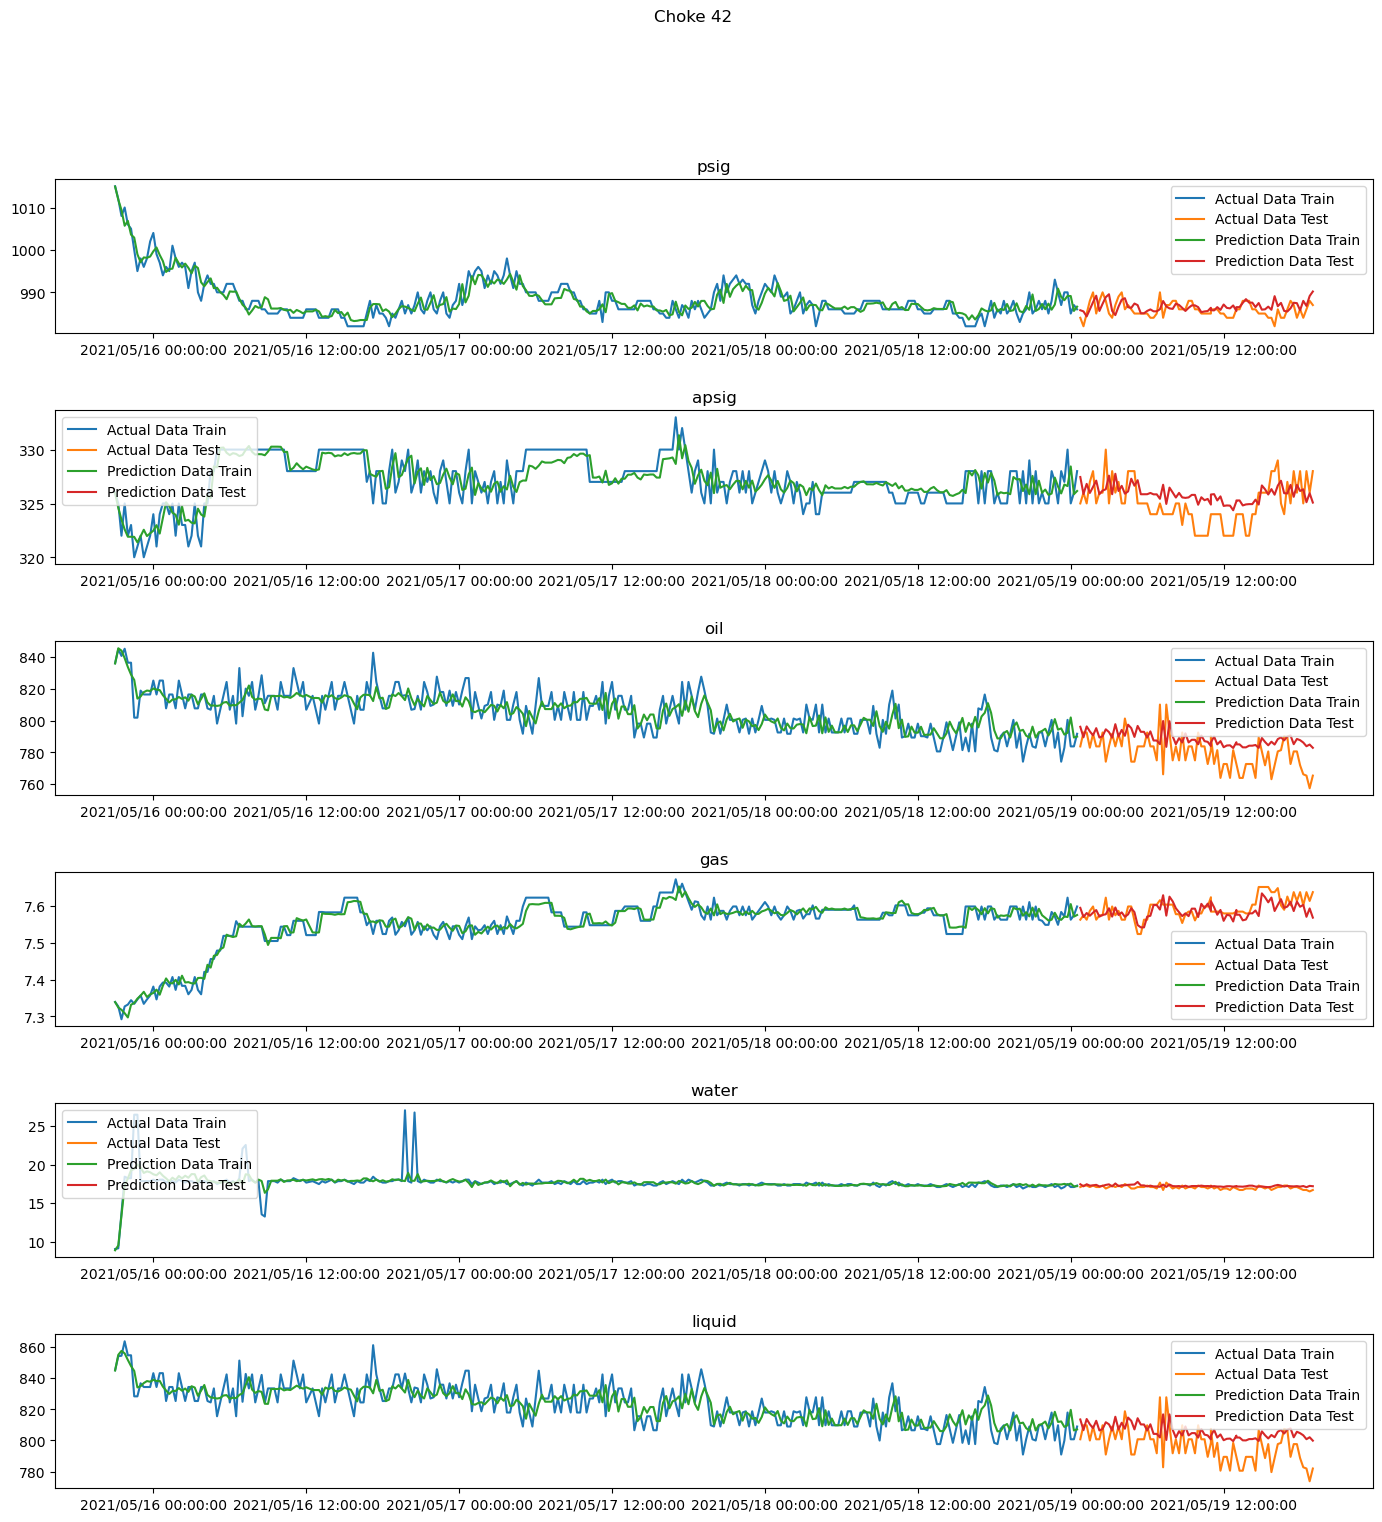

In [23]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_42_y.shape[1])

for i, ax in enumerate(axes):
    # Plot training data
    ax.plot(data['datetime'].iloc[:denormalized_train_42_y.shape[0]],
            denormalized_train_42_y.iloc[:, i], label='Actual Data Train')

    # Plot testing data
    ax.plot(data['datetime'].iloc[denormalized_train_42_y.shape[0]:denormalized_train_42_y.shape[0] + denormalized_test_42_y.shape[0]],
            denormalized_test_42_y.iloc[:, i], label='Actual Data Test')
    
    # Plot Prediction Training
    ax.plot(data['datetime'].iloc[:denormalized_train_42_y.shape[0]],
            denormalized_predictions_train_42.iloc[:, i], label='Prediction Data Train')

    # Plot predictions
    ax.plot(data['datetime'].iloc[denormalized_train_42_y.shape[0]:denormalized_train_42_y.shape[0] + denormalized_test_42_y.shape[0]],
            denormalized_predictions_42.iloc[:, i], label='Prediction Data Test')
    
    ax.set_title(denormalized_train_42_y.columns[i])
    ax.legend()
    format_date_ticks(ax)

fig.subplots_adjust(hspace=0.5)
fig.suptitle('Choke 42')
fig.savefig('cnn-lstm/choke_42.png')
fig.show()

## 4. Perbandingan Data Choke 38, 40, dan 42 pada setiap feature

/tmp/ipykernel_1555094/1465315998.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].bar(prediction_sums.keys(), [prediction_sum_38[i], prediction_sum_40[i], prediction_sum_42[i]], color=['red', 'green', 'blue'])
/tmp/ipykernel_1555094/1465315998.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


,Choke 38,Choke 40,Choke 42
psig,181177.093750,132399.656250,74988.867188
apsig,56512.300781,42042.140625,24767.607422
oil,123661.203125,95753.765625,59933.539062
gas,1106.966187,910.412109,576.614685
water,1765.062744,2006.492676,1310.649902
liquid,125378.312500,97690.281250,61228.640625


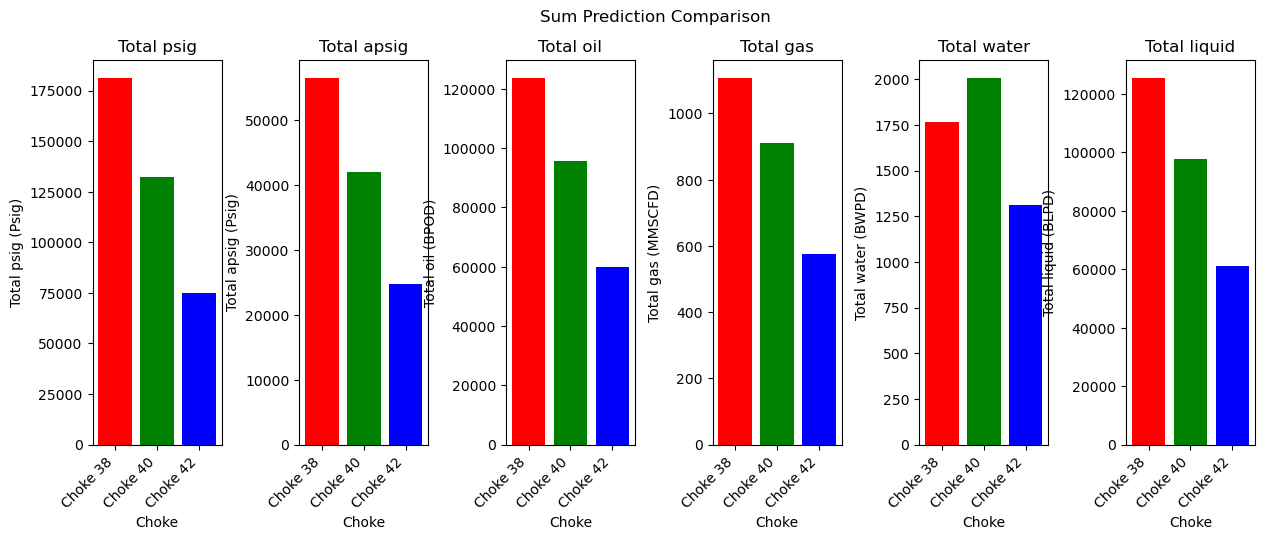

In [24]:
prediction_sum_38 = denormalized_predictions_38.sum()
prediction_sum_40 = denormalized_predictions_40.sum()
prediction_sum_42 = denormalized_predictions_42.sum()
prediction_sums = {
    'Choke 38': prediction_sum_38,
    'Choke 40': prediction_sum_40,
    'Choke 42': prediction_sum_42
}

units = ['Psig', 'Psig', 'BPOD', 'MMSCFD', 'BWPD', 'BLPD']

# plot sum prediction comparison bar
fig, axes = plt.subplots(figsize=(15, 5), ncols=len(prediction_sum_38.index))

for i, column in enumerate(prediction_sum_38.index):
    axes[i].bar(prediction_sums.keys(), [prediction_sum_38[i], prediction_sum_40[i], prediction_sum_42[i]], color=['red', 'green', 'blue'])
    axes[i].set_title('Total ' + column)
    axes[i].set_ylabel(f'Total {column} ({units[i]})')
    axes[i].set_xlabel('Choke')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

fig.subplots_adjust(wspace=0.6)
fig.suptitle('Sum Prediction Comparison')
fig.savefig('cnn-lstm/sum_prediction_comparison.png')
fig.show()

# display as table
pd.DataFrame(prediction_sums)

/tmp/ipykernel_1555094/2685019790.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i].bar(prediction_means.keys(), [prediction_mean_38[i], prediction_mean_40[i], prediction_mean_42[i]], color=['red', 'green', 'blue'])
/tmp/ipykernel_1555094/2685019790.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


,Choke 38,Choke 40,Choke 42
psig,1059.515137,1026.353882,986.695618
apsig,330.481293,325.908081,325.889557
oil,723.164917,742.277283,788.599182
gas,6.473486,7.057458,7.587035
water,10.322004,15.554207,17.245394
liquid,733.206482,757.289001,805.640015


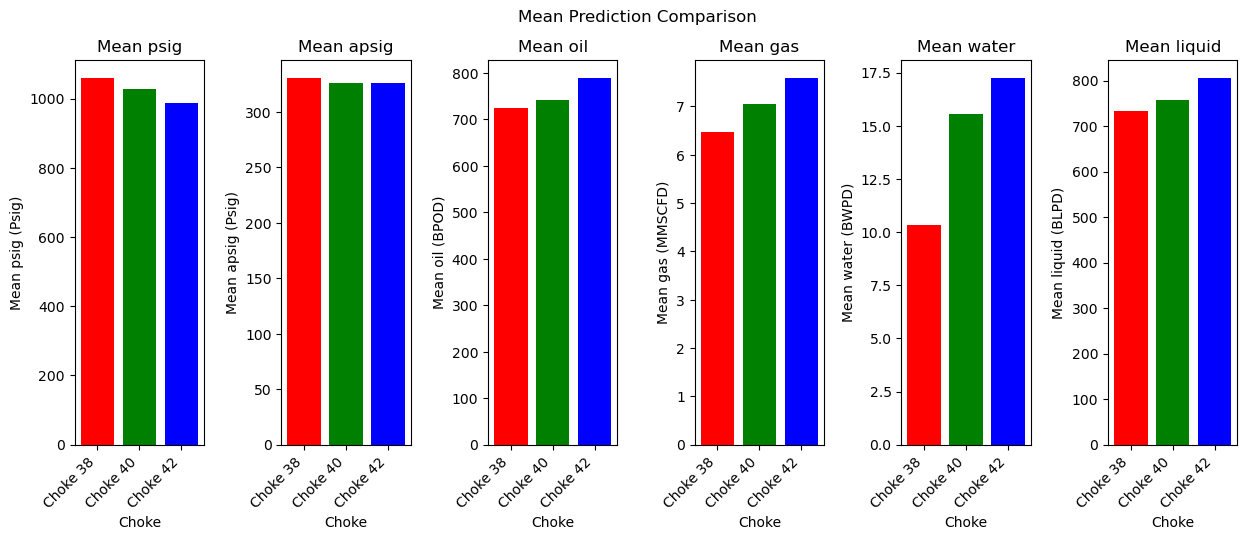

In [25]:
prediction_mean_38 = denormalized_predictions_38.mean()
prediction_mean_40 = denormalized_predictions_40.mean()
prediction_mean_42 = denormalized_predictions_42.mean()

prediction_means = {
    'Choke 38': prediction_mean_38,
    'Choke 40': prediction_mean_40,
    'Choke 42': prediction_mean_42
}

# plot mean prediction comparison bar
fig, axes = plt.subplots(figsize=(15, 5), ncols=len(prediction_mean_38.index))

for i, column in enumerate(prediction_mean_38.index):
    axes[i].bar(prediction_means.keys(), [prediction_mean_38[i], prediction_mean_40[i], prediction_mean_42[i]], color=['red', 'green', 'blue'])
    axes[i].set_title('Mean ' + column)
    axes[i].set_ylabel(f'Mean {column} ({units[i]})')
    axes[i].set_xlabel('Choke')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

fig.subplots_adjust(wspace=0.6)
fig.suptitle('Mean Prediction Comparison')
fig.savefig('cnn-lstm/mean_prediction_comparison.png')
fig.show()

# display as table
pd.DataFrame(prediction_means)

In [26]:
prediction_mean_38 = denormalized_predictions_38.mean()
prediction_mean_40 = denormalized_predictions_40.mean()
prediction_mean_42 = denormalized_predictions_42.mean()

features = ['psig', 'apsig', 'oil', 'gas', 'water', 'liquid']

prediction_mean_by_features_38 = {feature: prediction_mean_38[feature] for feature in features}
prediction_mean_by_features_40 = {feature: prediction_mean_40[feature] for feature in features}
prediction_mean_by_features_42 = {feature: prediction_mean_42[feature] for feature in features}

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'ext

/tmp/ipykernel_1555094/2522521877.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


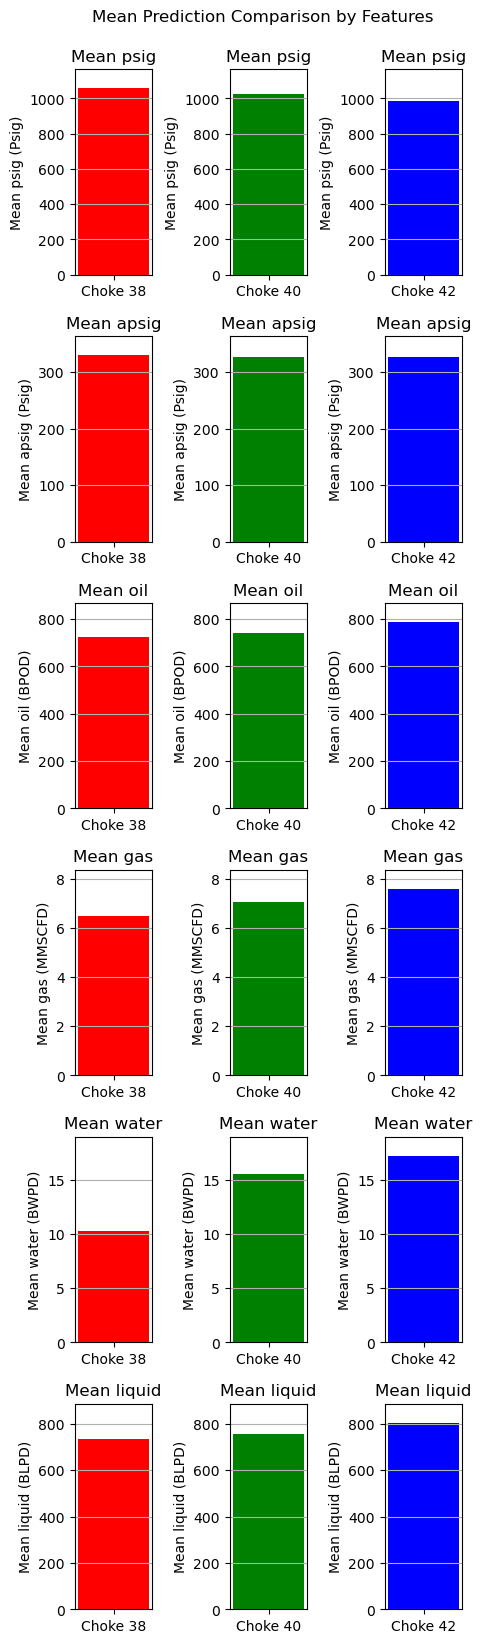

In [27]:
# plot mean prediction comparison bar by features
fig, axes = plt.subplots(figsize=(5, 20), nrows=6, ncols=3)

for i, feature in enumerate(features):
    axes[i, 0].bar(['Choke 38'], [prediction_mean_by_features_38[feature]], color=['red'])
    max_height = max(prediction_mean_by_features_38[feature], prediction_mean_by_features_40[feature], prediction_mean_by_features_42[feature])
    axes[i, 0].set_ylim(0, max_height * 1.1)
    axes[i, 0].set_title('Mean ' + feature)
    axes[i, 0].set_ylabel(f'Mean {feature} ({units[i]})')
    axes[i, 0].grid(True, axis='y')
    plt.setp(axes[i, 0].get_xticklabels())

for i, feature in enumerate(features):
    axes[i, 1].bar(['Choke 40'], [prediction_mean_by_features_40[feature]], color=['green'])
    max_height = max(prediction_mean_by_features_38[feature], prediction_mean_by_features_40[feature], prediction_mean_by_features_42[feature])
    axes[i, 1].set_ylim(0, max_height * 1.1)
    axes[i, 1].set_title('Mean ' + feature)
    axes[i, 1].set_ylabel(f'Mean {feature} ({units[i]})')
    axes[i, 1].grid(True, axis='y')
    plt.setp(axes[i, 1].get_xticklabels())

for i, feature in enumerate(features):
    axes[i, 2].bar(['Choke 42'], [prediction_mean_by_features_42[feature]], color=['blue'])
    max_height = max(prediction_mean_by_features_38[feature], prediction_mean_by_features_40[feature], prediction_mean_by_features_42[feature])
    axes[i, 2].set_ylim(0, max_height * 1.1)
    axes[i, 2].set_title('Mean ' + feature)
    axes[i, 2].set_ylabel(f'Mean {feature} ({units[i]})')
    axes[i, 2].grid(True, axis='y')
    plt.setp(axes[i, 2].get_xticklabels())

fig.subplots_adjust(hspace=0.3, wspace=1)
fig.suptitle('Mean Prediction Comparison by Features', y=0.91)
fig.savefig('cnn-lstm/mean_prediction_comparison_by_features.png')
fig.show()

# M. Kombinasikan Semua Data Prediksi


In [28]:
predictions_all = pd.concat([denormalized_predictions_train_38, denormalized_predictions_38, denormalized_predictions_train_40, denormalized_predictions_40, denormalized_predictions_train_42, denormalized_predictions_42])
predictions_all.reset_index(drop=True, inplace=True)
predictions_all['choke'] = [38] * len(denormalized_predictions_train_38) + [38] * len(denormalized_predictions_38) + [40] * len(denormalized_predictions_train_40) + [40] * len(denormalized_predictions_40) + [42] * len(denormalized_predictions_train_42) + [42] * len(denormalized_predictions_42)
predictions_all['datetime'] = data['datetime']
# move choke and datetime to front
predictions_all = predictions_all[['datetime', 'choke'] + [col for col in predictions_all.columns if col not in ['datetime', 'choke']]]
predictions_all.to_csv('cnn-lstm/predictions_all.csv', index=False)
predictions_all

,datetime,choke,psig,apsig,oil,gas,water,liquid
0,2021-05-15 21:00:00,38,940.706421,317.706940,728.771240,5.015408,27.755798,757.161499
1,2021-05-15 21:15:00,38,945.703796,317.063263,714.144043,5.003865,23.265125,739.118103
2,2021-05-15 21:30:00,38,935.202759,316.874298,725.087280,5.053494,28.677841,753.244263
3,2021-05-15 21:45:00,38,938.855042,316.089386,722.072266,5.071031,25.874977,747.724609
4,2021-05-15 22:00:00,38,936.206299,317.514526,729.216736,5.060074,29.400806,758.557617
...,...,...,...,...,...,...,...,...
1870,2021-06-04 07:15:00,42,985.810120,326.161407,787.633240,7.598274,17.151518,804.675110
1871,2021-06-04 07:30:00,42,988.020874,326.319427,786.141541,7.603437,17.226997,803.316650
1872,2021-06-04 07:45:00,42,986.825256,325.121155,783.817383,7.571005,17.077650,800.813171
1873,2021-06-04 08:00:00,42,989.157410,325.956726,784.881042,7.593674,17.246773,802.060486


# N. Visualisasi Data Prediksi

/tmp/ipykernel_1555094/242305396.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


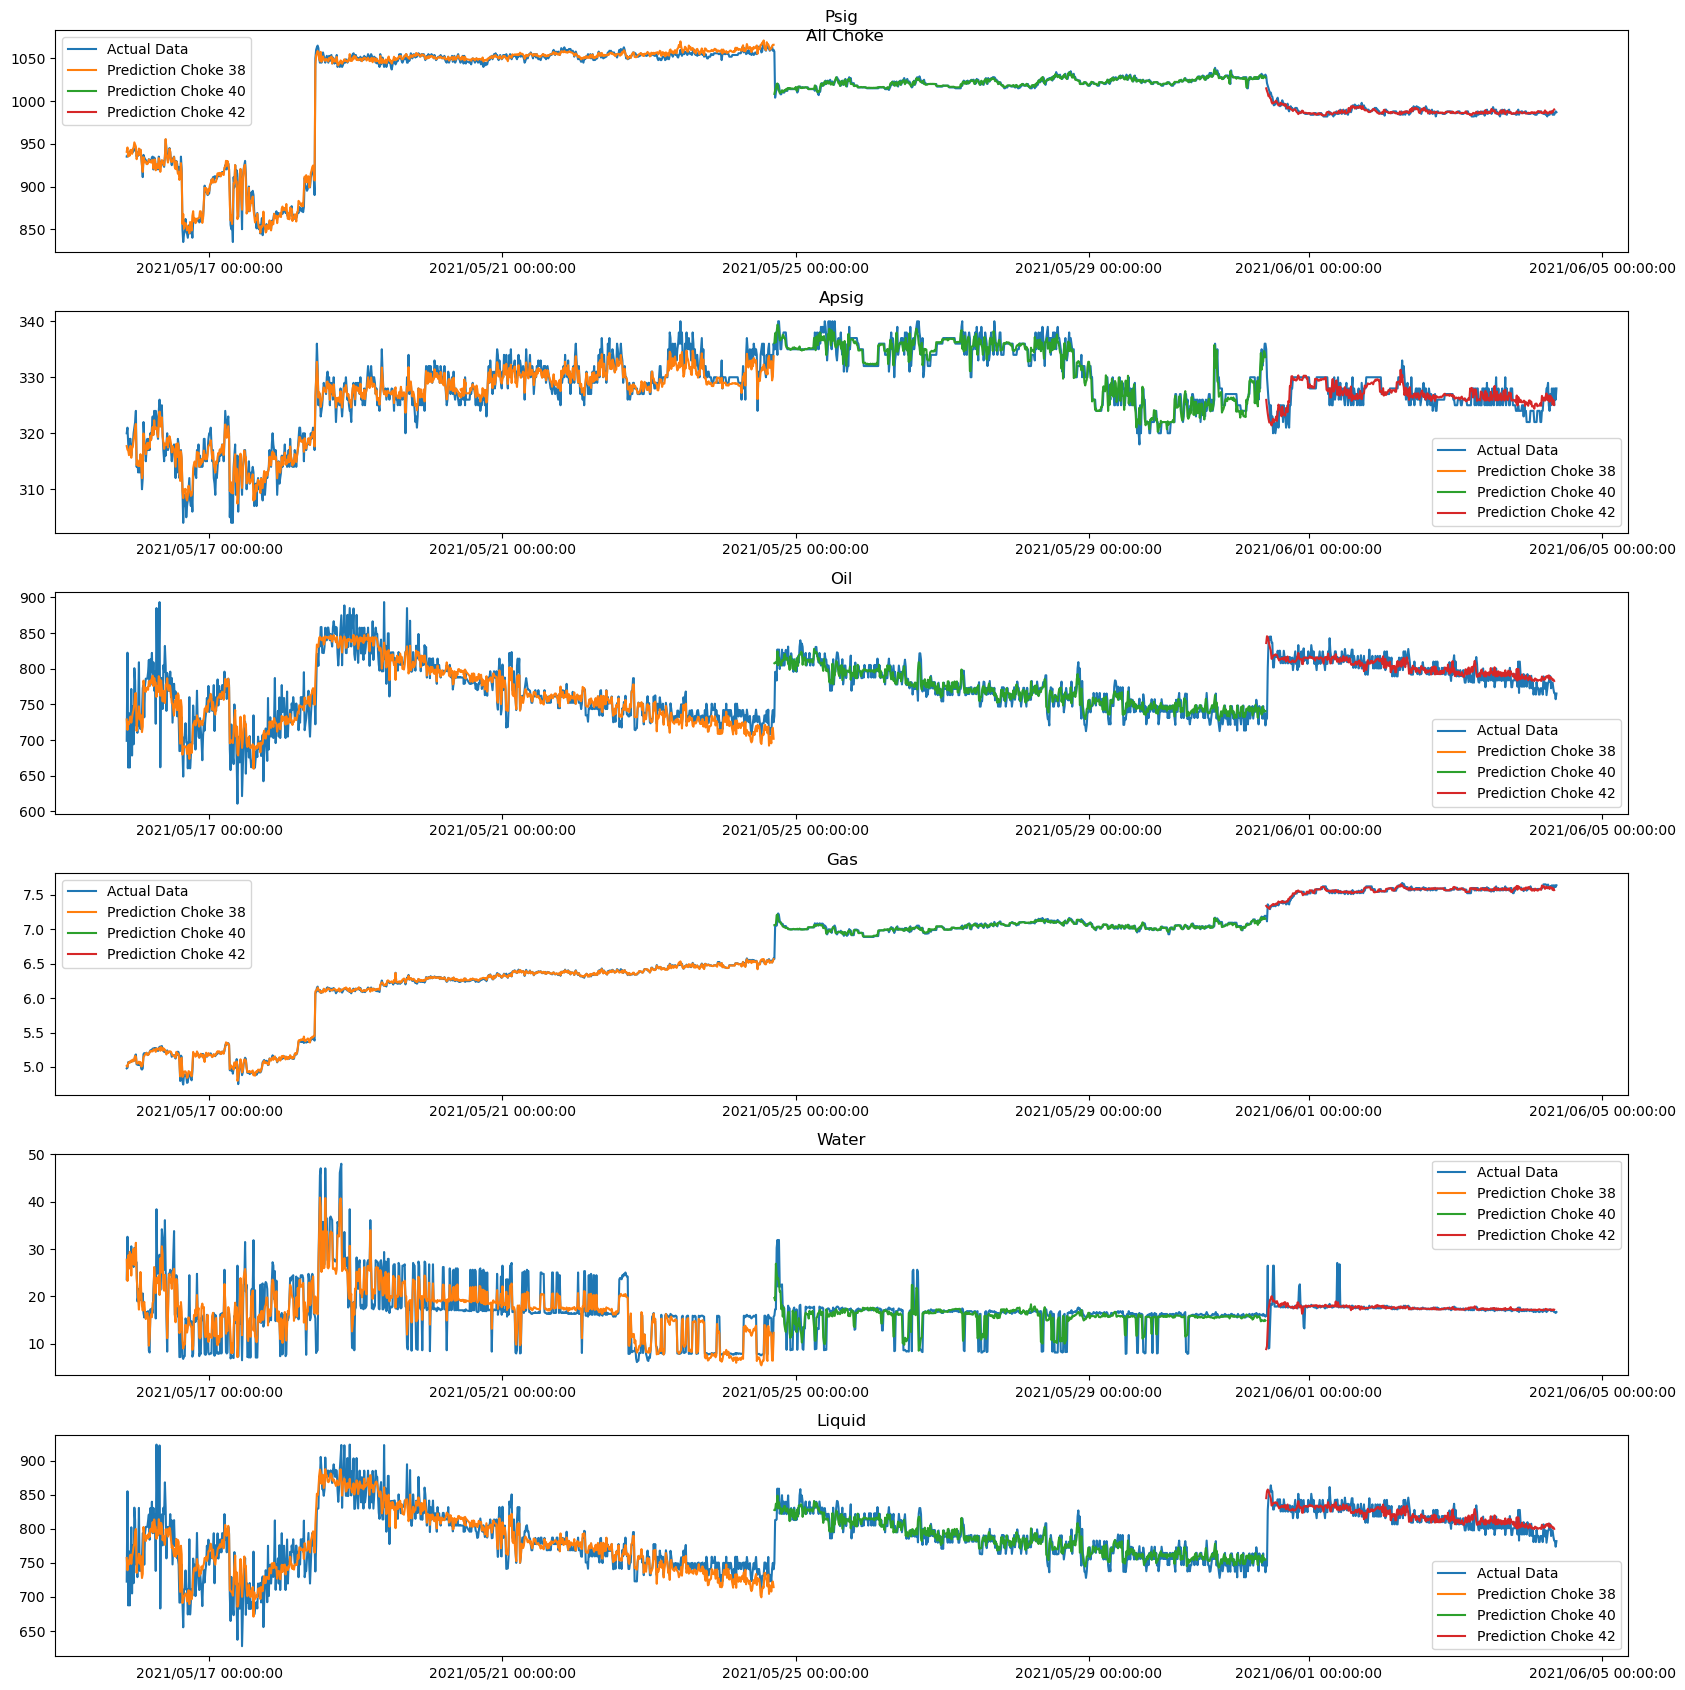

In [29]:
fig, axes = plt.subplots(figsize=(17, 17), nrows=denormalized_train_38_y.shape[1])
for i, ax in enumerate(axes):
    ax.plot(data['datetime'], data[data.columns[i+2]], label='Actual Data')

    for choke in [38, 40, 42]:
        ax.plot(predictions_all[predictions_all['choke'] == choke]['datetime'], predictions_all[predictions_all['choke'] == choke][predictions_all.columns[i+2]], label=f'Prediction Choke {choke}')

    ax.set_title(data.columns[i+2].capitalize())
    format_date_ticks(ax)
    ax.legend()
  
plt.tight_layout()
fig.suptitle('All Choke')
fig.savefig('cnn-lstm/all_choke.png')
fig.show()

# O. Ratio Liquid Output

In [30]:
predictions_all_date = predictions_all.copy()
predictions_all_date['date'] = predictions_all_date['datetime'].dt.date
predictions_all_date['week'] = predictions_all_date['datetime'].dt.isocalendar().week
predictions_all_date['month'] = predictions_all_date['datetime'].dt.month

# SUM
predictions_all_date_grouped_sum = predictions_all_date.drop(['week', 'month', 'liquid'], axis=1).groupby(['choke', 'date']).sum(numeric_only=True).reset_index()
# predictions_all_date_grouped_sum['liquid']
predictions_all_date_grouped_sum.to_csv('cnn-lstm/predictions_all_date_grouped_sum.csv', index=False)

predictions_all_week_grouped_sum = predictions_all_date.drop(['date', 'month', 'liquid'], axis=1).groupby(['choke', 'week']).sum(numeric_only=True).reset_index()
# predictions_all_week_grouped_sum['liquid']
predictions_all_week_grouped_sum.to_csv('cnn-lstm/predictions_all_week_grouped_sum.csv', index=False)

predictions_all_month_grouped_sum = predictions_all_date.drop(['week', 'date', 'liquid'], axis=1).groupby(['choke', 'month']).sum(numeric_only=True).reset_index()
# predictions_all_month_grouped_sum['liquid']
predictions_all_month_grouped_sum.to_csv('cnn-lstm/predictions_all_month_grouped_sum.csv', index=False)

# MEAN
predictions_all_date_grouped_mean = predictions_all_date.drop(['week', 'month', 'liquid'], axis=1).groupby(['choke', 'date']).mean(numeric_only=True).reset_index()
# predictions_all_date_grouped_mean['liquid']
predictions_all_date_grouped_mean.to_csv('cnn-lstm/predictions_all_date_grouped_mean.csv', index=False)

predictions_all_week_grouped_mean = predictions_all_date.drop(['date', 'month', 'liquid'], axis=1).groupby(['choke', 'week']).mean(numeric_only=True).reset_index()
# predictions_all_week_grouped_mean['liquid']
predictions_all_week_grouped_mean.to_csv('cnn-lstm/predictions_all_week_grouped_mean.csv', index=False)

predictions_all_month_grouped_mean = predictions_all_date.drop(['week', 'date', 'liquid'], axis=1).groupby(['choke', 'month']).mean(numeric_only=True).reset_index()
# predictions_all_month_grouped_mean['liquid']
predictions_all_month_grouped_mean.to_csv('cnn-lstm/predictions_all_month_grouped_mean.csv', index=False)

display(predictions_all_date_grouped_sum)
display(predictions_all_date_grouped_mean)
display(predictions_all_week_grouped_sum)
display(predictions_all_week_grouped_mean)
display(predictions_all_month_grouped_sum)
display(predictions_all_month_grouped_mean)

,choke,date,psig,apsig,oil,gas,water
0,38,2021-05-15,11310.425781,3812.532959,8803.181641,60.917694,328.734741
1,38,2021-05-16,86058.593750,30030.039062,70650.812500,487.949066,1698.127686
2,38,2021-05-17,84915.820312,30135.033203,69297.226562,487.368530,1490.328369
3,38,2021-05-18,93652.531250,30973.058594,76298.468750,551.415588,2237.493652
4,38,2021-05-19,102905.093750,32094.107422,80373.273438,608.682922,2112.855469
5,38,2021-05-20,105017.578125,32858.636719,78995.085938,628.491333,1941.663818
6,38,2021-05-21,101218.250000,31718.607422,73253.125000,611.034729,1722.482178
7,38,2021-05-22,101152.929688,31682.259766,72011.250000,611.250305,1526.186279
8,38,2021-05-23,101608.640625,31746.886719,69885.859375,619.904236,1072.965820
9,38,2021-05-24,72180.140625,22467.417969,48620.886719,442.178650,627.517883


,choke,date,psig,apsig,oil,gas,water
0,38,2021-05-15,942.535461,317.711090,733.598450,5.076475,27.394562
1,38,2021-05-16,905.879944,316.105682,743.692749,5.136306,17.875029
2,38,2021-05-17,884.539795,313.906586,721.846130,5.076756,15.524254
3,38,2021-05-18,975.547180,322.636017,794.775696,5.743912,23.307226
4,38,2021-05-19,1050.052002,327.490906,820.135437,6.211050,21.559750
5,38,2021-05-20,1050.175781,328.586365,789.950867,6.284914,19.416637
6,38,2021-05-21,1054.356812,330.402161,763.053406,6.364945,17.942522
7,38,2021-05-22,1053.676392,330.023529,750.117188,6.367191,15.897774
8,38,2021-05-23,1058.423340,330.696747,727.977722,6.457336,11.176727
9,38,2021-05-24,1061.472656,330.403198,715.013062,6.502627,9.228204


,choke,week,psig,apsig,oil,gas,water
0,38,19,97369.015625,33842.570312,79454.000000,548.866760,2026.862427
1,38,20,690470.875000,221208.593750,520114.281250,4118.147461,12103.975586
2,38,21,72180.140625,22467.417969,48620.886719,442.178650,627.517883
3,40,21,616942.500000,200574.734375,465510.687500,4248.069824,9492.826172
4,40,22,41064.976562,13097.226562,29623.314453,283.338867,622.376038
5,42,22,373532.750000,123571.210938,303338.625000,2856.531982,6641.688965


,choke,week,psig,apsig,oil,gas,water
0,38,19,909.990784,316.285706,742.560730,5.129596,18.942640
1,38,20,1018.393616,326.266357,767.130188,6.073964,17.852472
2,38,21,1061.472656,330.403198,715.013062,6.502627,9.228204
3,40,21,1021.427979,332.077362,770.713074,7.033228,15.716599
4,40,22,1026.624390,327.430664,740.582886,7.083472,15.559401
5,42,22,988.181885,326.907959,802.483154,7.556963,17.570606


,choke,month,psig,apsig,oil,gas,water
0,38,5,860020.000000,277518.593750,648189.187500,5109.192871,14758.355469
1,40,5,658007.500000,213671.953125,495134.000000,4531.408691,10115.202148
2,42,5,55661.167969,18267.822266,45732.140625,416.616638,996.626587
3,42,6,317871.593750,105303.390625,257606.500000,2439.915283,5645.062500


,choke,month,psig,apsig,oil,gas,water
0,38,5,1008.229797,325.344177,759.893555,5.989675,17.301706
1,40,5,1021.750793,331.788757,768.841614,7.036349,15.706836
2,42,5,993.949402,326.211121,816.645386,7.439583,17.796904
3,42,6,987.178833,327.029175,800.020203,7.577377,17.531250
